# Evaluation

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pickle

from collections import defaultdict
from kickoff_web.database import Match, Competition, Team, queries
from datetime import datetime, timezone
from math import log

## Get log losses

In [2]:
def get_probs(file):
    '''Expects a text file with probabilities ordered by match kickoff time.'''
    with open(file) as f:
        probs = dict()
        for line in f.readlines():
            i, w, d, l = line.rsplit(None, 3)
            probs[int(i)] = [float(w)/100, float(d)/100, float(l)/100]
        return probs

def get_ll(probs):
    begin = datetime(2018, 6, 14, tzinfo=timezone.utc)
    ll = list()
    for i, m in enumerate((Match.select()
            .join(Competition)
            .where(
                    Competition.name == "World Cup",
                    Match.kickoff_time > begin,
                    Match.outcome != "N/A")
             .order_by(Match.kickoff_time))):
        if m.score_a_ft > m.score_b_ft:
            ll.append(-log(probs[m.id][0]))
        elif m.score_a_ft < m.score_b_ft:
            ll.append(-log(probs[m.id][2]))
        else:
            ll.append(-log(probs[m.id][1]))
#         print(i, m.id, m.team_a.name, m.team_b.name, m.kickoff_time)
    return ll

### Google

In [3]:
probs_google = get_probs('google.txt')

ll_google = get_ll(probs_google)

print('Average log loss: {:.4f}'.format(np.mean(ll_google)))

Average log loss: 0.9442


### FiveThirtyEight

In [4]:
probs_538 = get_probs('fivethirtyeight.txt')

ll_538 = get_ll(probs_538)
print('Average log loss: {:.4f}'.format(np.mean(ll_538)))

Average log loss: 0.8968


### Kickoff.ai

In [5]:
probs_kai = dict()
for p in (queries.get_predictions("results", limit=64, comp_id=14)
            .order_by(Match.kickoff_time.asc())):
    probs_kai[p.match_id] = p.probabilities

ll_kai = get_ll(probs_kai)
print('Average log loss: {:.4f}'.format(np.mean(ll_kai)))

Average log loss: 0.9593


### Betting odds

In [6]:
with open('betting-odds-probs.pkl', 'rb') as f:
    probs_bet = pickle.load(f)
    
ll_bet = get_ll(probs_bet)
print('Average log loss: {:.4f}'.format(np.mean(ll_bet)))

Average log loss: 0.9416


In [29]:
with open('betting-odds-ll.pkl', 'rb') as f:
    bet = pickle.load(f)
    
ll_bet = list()
for i in range(64):
    ll = list()
    for bookmaker, loss in sorted(bet.items(), key=lambda x: x[1]):
        ll.append(loss[i])
    ll_bet.append(np.mean(ll))
    
print('Average log loss: {:.4f}'
      .format(np.mean(ll_bet)))

Average log loss: 0.9420


## Plots

### Group phase

[1.0986122886681098, 0.9247726682177024, 0.9329650557696999, 0.917796097655644, 0.9310837433953975]


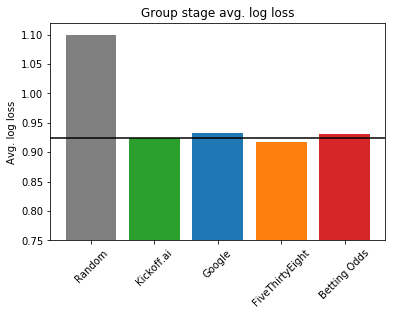

In [7]:
order = ['random', 'kai', 'google', '538', 'bet']
ticks = {
    'random': 'Random',
    'kai': 'Kickoff.ai',
    'google': 'Google',
    '538': 'FiveThirtyEight',
    'bet': 'Betting Odds'
}
col = {
    'random': 'gray',
    'kai': 'C2',
#     'kai': '#00BF7C',
    'google': 'C0',
    '538': 'C1',
    'bet': 'C3'
}

lls = {
    'random': [-np.log(1/3)] * len(ll_kai),
    'kai': ll_kai,
    'google': ll_google,
    '538': ll_538,
    'bet': ll_bet
}


def bar(i, j, lls, order, ticks, col, title):
    x = np.arange(len(order))
    lls = [np.mean(lls[k][i:j]) for k in order]
    print(lls)
    fig, ax = plt.subplots()
    plt.bar(x, lls, color=[col[k] for k in order])
    plt.xticks(x, [ticks[k] for k in order], rotation=45)
    plt.axhline(np.mean(lls[order.index('kai')]), color='k')
    plt.ylim([0.75, 1.12])
    plt.title(title)
    plt.ylabel('Avg. log loss')
    plt.show()

bar(0, 48, lls, order, ticks, col, 'Group stage avg. log loss')

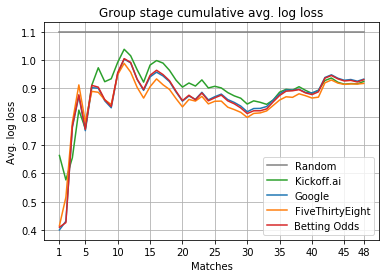

In [8]:
def avgcumloss(i, j, order, title, locs, labels):
    x = np.arange(start=i, stop=j)
    cumavg = {k: np.cumsum(lls[k])[i:j] / (x + 1) for k in order}
    
    for k in order:
        plt.plot(x, cumavg[k], color=col[k], label=ticks[k])
    plt.title(title)
    plt.ylabel('Avg. log loss')
    plt.xlabel('Matches')
    plt.xticks(locs, labels)
    plt.legend()
    plt.grid()
    plt.show()

order = ['random', 'kai', 'google', '538', 'bet']
locs = [0] + list(np.arange(4, 45, 5)) + [47]
labels = np.array(locs) + 1
avgcumloss(i=0, j=48, order=order, title='Group stage cumulative avg. log loss',
          locs=locs, labels=labels)

### Knockout stage

[1.0986122886681098, 1.06295179872393, 0.9781022176761078, 0.9729606145738818]


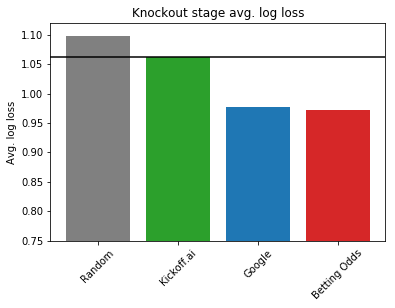

In [9]:
order = ['random', 'kai', 'google', 'bet']
bar(48, 64, lls, order, ticks, col, 'Knockout stage avg. log loss')

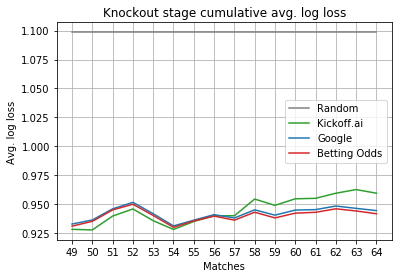

In [10]:
order = ['random', 'kai', 'google', 'bet']
locs = np.arange(48, 64)
labels = locs + 1
avgcumloss(i=48, j=64, order=order,
           title='Knockout stage cumulative avg. log loss',
           locs=locs, labels=labels)

## Previous editions

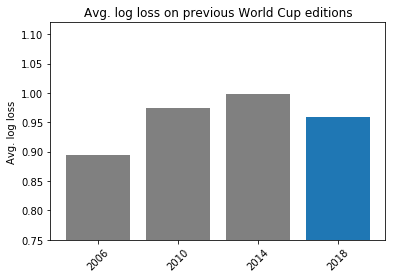

In [11]:
order = [2006, 2010, 2014, 2018]
lls = {
    2006: 0.895,
    2010: 0.975,
    2014: 0.999,
    2018: 0.959
}

col = {
    2006: 'gray',
    2010: 'gray',
    2014: 'gray',
    2018: 'C0'
}

ticks = {c: c for c in order}

x = np.arange(len(order))
fig, ax = plt.subplots()
plt.bar(x, [lls[k] for k in order], color=[col[k] for k in order])
plt.xticks(x, [ticks[k] for k in order], rotation=45)
plt.ylim([0.75, 1.12])
plt.title('Avg. log loss on previous World Cup editions')
plt.ylabel('Avg. log loss')
plt.show()

## Compile data

In [47]:
data = list()
for i, m in enumerate((Match.select()
            .join(Competition)
            .where(
                    Competition.name == "World Cup",
                    Match.kickoff_time > begin,
                    Match.outcome != "N/A")
             .order_by(Match.kickoff_time))):
    row = [i+1, m.team_a.name, m.team_b.name]
    row.extend(['{:0.4f}'.format(p) for p in probs_kai[m.id]])
    row.extend(['{:0.2f}'.format(p) for p in probs_google[m.id]])
    row.extend(['{:0.2f}'.format(p) for p in probs_538[m.id]])
    row.extend(['{:0.4f}'.format(p) for p in probs_bet[m.id]])
    
    data.append(row)

In [48]:
header = [
    'match_id', 'team_a', 'team_b',
    'kickoffai_win_a', 'kickoffai_tie', 'kickoffai_win_b',
    'google_win_a', 'google_tie', 'google_win_b',
    'fivethirtyeight_win_a', 'fivethirtyeight_tie', 'fivethirtyeight_win_b',
    'bettingodds_win_a', 'bettingodds_tie', 'bettingodds_win_b'
         ]

In [49]:
with open('wc2018-probabilities.csv', 'w+') as f:
    f.write(','.join(header))
    f.write('\n')
    for datum in data:
        f.write(','.join([str(d) for d in datum]))
        f.write('\n')